In [2]:
import pandas as pd
import requests
import re
import nltk
import gensim
import string
from bs4 import BeautifulSoup
from nltk.corpus import gutenberg
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pin.lyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/pin.lyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Access a specific text

text_name = "shakespeare-hamlet.txt"

text = gutenberg.raw(text_name)

In [4]:
def preprocess(text):
    
    text = text.lower()                                 # Lower case all words
    
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    
    tokens = word_tokenize(text)                        # Tokenize words
    
    stop_words = set(stopwords.words("english"))        # Activate stop words identifier

    lemmatizer = WordNetLemmatizer()                    # Initialize lemmatizer
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]  # Lemmatize filtered words
    
    return tokens

In [5]:
# Process the text 

processed_text = preprocess(text)

In [6]:
# Convert text into a document-term matrix

dictionary = corpora.Dictionary([processed_text])

corpus = [dictionary.doc2bow(processed_text)]

In [7]:
# Apply LDA model

num_topics = 3  # Set number of topics

lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

In [8]:
## Results

# Extract topics

topics = lda_model.print_topics(num_words=10)

# Convert topics into a structured list

topic_data = []

for i, topic in topics:
    
    words = re.findall(r'\"(.*?)\"', topic)  # Extract words from the topic string
    
    topic_data.append([f"Topic {i+1}"] + words)

# Convert to a DataFrame

columns = ["Topic"] + [f"Word {j+1}" for j in range(10)]

hamlet_topics = pd.DataFrame(topic_data, columns=columns)

# Display DataFrame

hamlet_topics

,Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
0,Topic 1,ham,lord,haue,king,come,shall,let,hamlet,hor,enter
1,Topic 2,ham,lord,king,haue,come,let,shall,hamlet,thou,good
2,Topic 3,ham,king,lord,haue,hamlet,shall,thou,thy,come,good


### Non-negative Matrix Factorization (NMF)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [11]:
# Step 4: Convert text into a TF-IDF matrix

vectorizer = TfidfVectorizer(max_features=1000)

tfidf_matrix = vectorizer.fit_transform([" ".join(processed_text)])

In [12]:
# Step 5: Apply NMF model

num_topics = 3  # Set number of topics

nmf_model = NMF(n_components=num_topics, random_state=42)

nmf_features = nmf_model.fit_transform(tfidf_matrix)

/Applications/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:136: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(res * 2)


In [13]:
# Step 6: Display topics

words = vectorizer.get_feature_names_out()

topic_data = []

for topic_idx, topic in enumerate(nmf_model.components_):
    
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
    
    topic_data.append([f"Topic {topic_idx+1}"] + top_words)

In [14]:
# Convert to a DataFrame

columns = ["Topic"] + [f"Word {j+1}" for j in range(10)]

hamlet_topics = pd.DataFrame(topic_data, columns=columns)

# Display DataFrame

hamlet_topics

,Topic,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
0,Topic 1,ham,lord,king,haue,come,shall,hamlet,let,thou,good
1,Topic 2,kinde,vp,greefe,horatio,heauens,againe,play,long,helpe,get
2,Topic 3,fran,fall,cause,beleeue,memory,law,blood,anon,seruice,writ


### Notes
Differences between LDA & Non-negative Matrix Factorization

#### LDA (Probabilistic Model):

- Assumes topics are distributions over words and documents are distributions over topics.
- Uses a generative probabilistic model based on Dirichlet distributions.
- Works by iteratively refining topic probabilities using algorithms like Gibbs sampling or Variational Inference.

#### NMF (Matrix Factorization Model):

- Assumes that a document-word matrix (e.g., TF-IDF) can be factorized into two lower-dimensional matrices:
    - W (documents × topics)
    - H (topics × words)
- Relies purely on linear algebra (minimizing the difference between the original and reconstructed matrix).
- Requires non-negative values (hence, cannot handle raw text directly).


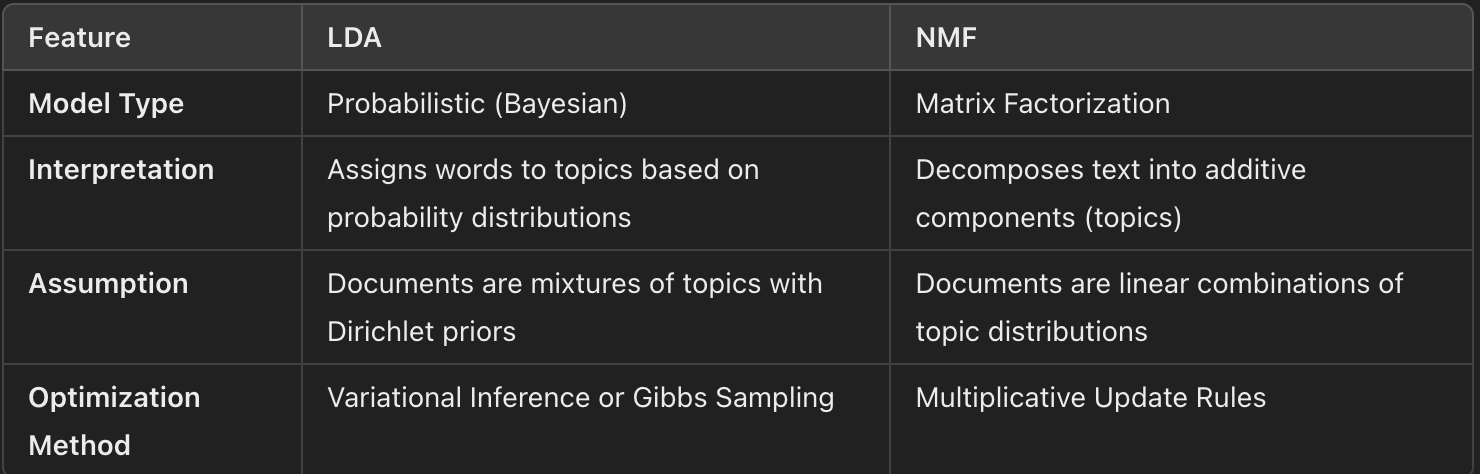